## 논문 요약
- 네트워크는 hidden layer마다 Input분포가 달라지는 Internal Covariate Shift 라는 문제점이 발생 -> 이는 수렴속도를 감소시키고 학습성능을 저해함
- 이를 해결하기 위한 방안 : Batch Normalization -> 각 Batch의 통계량을 이용해 레이어의 노드마다 Normalization을 수행함

이 논문은 딥러닝을 학습 시킬 때 사용하는 옵티마이저의 성능개선에 관한 논문임

## Abstract
DNN(Deep Neural Network)을 학습시킬 때 SGD(Stochastic Gradient Descent) 기반의 방법론을 쓰면 각 레이어별로 입력의 분포가 변화합니다. 결과적으로 내부 input feature의 분포가 계속 변하는 **Internal Covariate Shift** (내부 공변량 변화, ICS)가 발생 -> 즉, train을 통해 찾아내는 feature 분포와 실제 test dataset의 feature 분포가 서로 달라지게 됩니다.

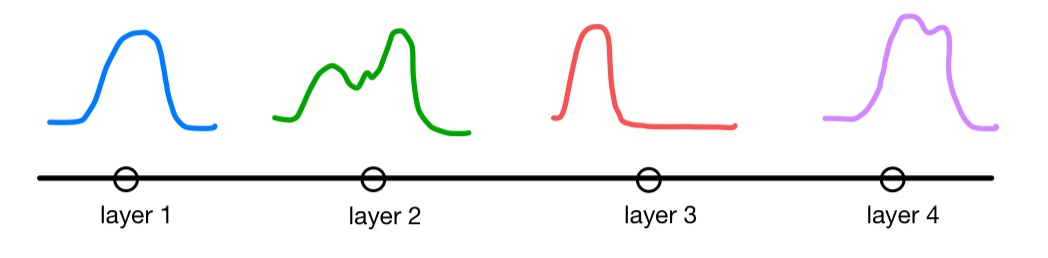
아무튼 이렇게 분포가 편향되는 문제가 발생되서
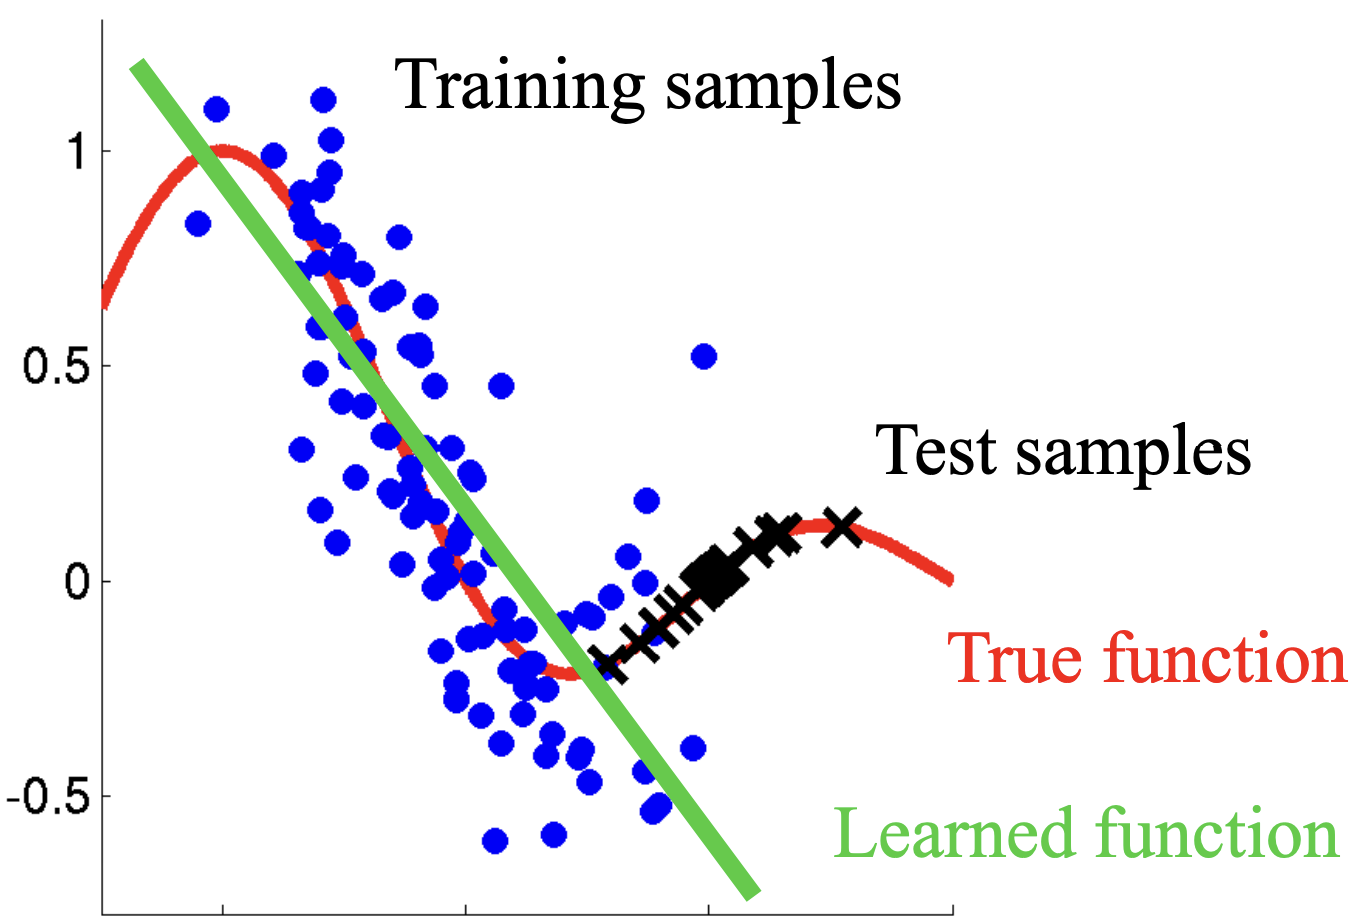
학습의 성능이 별로 안좋아 진다는 뜻임

## 1. 서론
SGD 목적 : DNN을 수식화 할때 아래의 파라미터 $\theta$를 최적화 시키는게 목적임
$$
\theta = \arg \min_{\theta} \frac{1}{N} \sum_{i=1}^N L(x_i, \theta)
$$

이게 레이어가 여러개 쌓이게 되면 아래의 수식처럼 $\theta$가 연쇄된 업데이트 과정을 갖게됨
$$
\ell = F_2(F_1(u, \theta_1), \theta_2)
$$
$$
\ell = F_2(x, \theta_2)
$$
$$
\theta_2 \leftarrow \theta_2 - \frac{\alpha}{m} \sum_{i=1}^m \frac{\partial F_2(x_i, \theta_2)}{\partial \theta_2}
$$

따라서 전체 모델은 $x = F_1(u, \theta_1)$ 을 연쇄하여 입력받는 네트워크의 묶음(sub network)으로 볼 수 있고, 논문은  $x$의 분포도가 어느정도 고정되는 것이 수렴(모델의 학습 성능)에 도움을 준다 말하고 있다.
-> 따라서 입력되는 $x$의 분포가 크게 변하지 않는다면 $\theta_n$은 안정적인 학습결과를 낼 것이다 라는 것이 논문의 주장

## 2. 본론 (Towards Reducing Internal Covariate Shift)

논문의 저자들이 문제를 해결하기 위해 처음 시도한 방법 -> Train stap마다 활성화 함수(Activation Function, ReLU같은거)를 적용할 때 Whitening (데이터에서 각 feature의 평균을 제거하고, 모든 feature가 단위 분산을 갖도록 스케일링하는 과정)을 적용하는 방안을 사용
-> 이 과정을 도입할 시 수렴 과정에서 gradient descent가 제대로 이뤄지지 않는 문제가 발생

이 문제에 대한 수식적인 해석
가정 : input $u$, bias $b$를 갖는 레이어 -> Activation 평균을 가지고 Normalization을 적용

$$x = u + b, \quad X = \{x_1, \ldots, x_N\}$$

$$ \hat{x} = x - E[x], \text{ where } E[x] = \frac{1}{N} \sum_{i=1}^N x_i $$

여기서 Gradient Desent를 적용 시 bias $b$는 아래와 같이 업데이트됨
$$b \leftarrow b + \Delta b$$

이후 Normaliztion을 적용하면 레이어의 출력이 아래와 같이 변동
$$u + (b + \Delta b) - E[u + (b + \Delta b)] = u + b - E[u + b]$$
$$ = x - E[x]$$

결과적으로 Normaliztion을이 출력에 영향을 끼치는 문제가 발생함 -> 이는 오차 역전파(Back-propagation)과정에서 Normalization의 효과가 반영안된다는 것을 의미

## 토막상식

-- 여기서 Batch Normalization 이란?
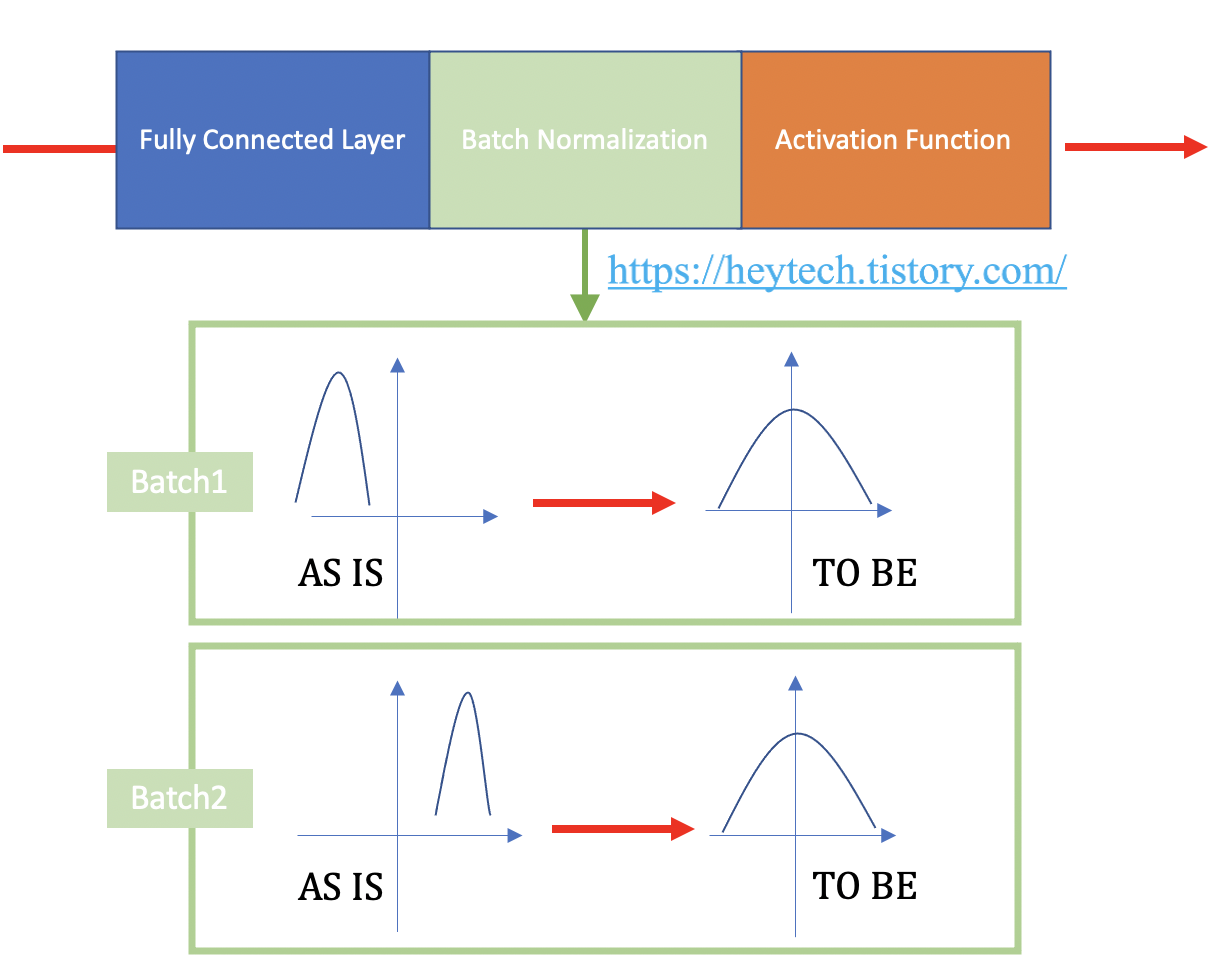
배치 정규화(Batch Normalization)는 학습 과정에서 Batch마다 평균과 분산을 활용하여 데이터의 분포를 정규화하는 과정을 말합니다(그림 3). 데이터 종류에 따라 값의 범위는 천차만별이기 때문에, Batch마다 입력값의 범위를 스케일링하는 과정이 바로 Batch Normalization입니다.

장점 : 스케일 통일, 활성화 함수 맟춤형 분포 변화

아무튼 논문에서 normalization의 효과가 반영되지 않는 것에 대한 문제 해결방법

모든 input data 에 대하여 출력된 Activation이 정해진 분포(Distribution)를 따르는 Normaization 함수 $Norm$을 가정함
-> 이걸 만들면 Gradient Descent로 Loss 계산시 Normaization과정의 영향력을 포함시키는것이 가능함
$x$를 레이어의 input vector $X$, 즉 전체 데이터에서 생성되는 모든 input vector이라 하면 아래와 같은 수식으로 표현 가능

$$\hat{x} = \text{Norm}(x, X)$$
-> 위 식을 미분 -> Jacobian 매트릭스 만들어짐
자코비안 매트릭스 아래거 계산해야함
$$\frac{\partial \text{Norm}}{\partial x}, \frac{\partial \text{Norm}}{\partial X}$$
최종적으로 이거 계산해야함
$$\text{Cov}[x] = E[x x^T] - E[x]E[x]^T + \frac{1}{\sqrt{\text{Cov}[x]}}$$

-> 연산량이 많아지는 문제가 발생함

## 3. Normalization via Mini-Batch Statistics

2번에서 제시한 whitening 과정은 결론적으로 연산 Cost가 매우 높음
따라서 아래의 2가지 방법으로 간소화 방안을 제시

 - input data $x$의 dimension(차원)에 대한 정구화 수행
 - 각 Batch의 mean, variance를 통해 모평균/분산을 추정함

 위 과정을 수식으로 표현해보자
 일단 $d$개의 차원을 가진 input $x = \{x_1, \ldots, x_m\}$에 대하여 normaliza를 적용한 $\hat{x}$는 아래와 같다.
$$ \hat{x} = \frac{x_k - E[x_k]}{\sqrt{\text{Var}[x_k]}} $$

이렇게 $x$를 whitening을 하면 각 레이어의 representation(재현)이 변형될 수 있음(레이어의 출력을 representation 이라 표현하는데 이게 변조된다는 뜻으로 지금 풀이를 하고있음)

이렇게 변조가 되는 이유 : Activation Function을 적용하면 값에 왜곡이 발생함

-> 그래서 transformation과정에서 nonlinearity를 유지하도록 조정을 해줌
$$ y_k = \gamma_k \hat{x}_k + \beta_k $$

위 수식은 일반적으로 Batch Normalization 과정에서 스케일링과 시프트를 적용하여 데이터의 정규화된 형태를 다시 조정하는 과정을 나타냅니다. 여기서 $\gamma_k$와 $\beta_k$는 학습 가능한 파라미터로, 각각 스케일과 시프트(편향) 역할을 합니다.

위 learnable parameter $\gamma, \beta$는 경우에 따라 $\gamma_k = \sqrt{\text{Var}[x_k]}, \beta_k = E[x_k]$ 가 되기도 함

아무튼 레이어의 출력(representation)이 변형되지 않도록 스케일링 + 쉬프트닝(scaling & shifting)을 수행한다.

**Input:** Values of $x$ over a mini-batch: $ \mathbf{B} = \{x_1...x_m\} $; Parameters to be learned: $ \gamma, \beta $

**Output:** $ \{y_i = BN_{\gamma, \beta}(x_i)\} $

1. $ \mu_B \leftarrow \frac{1}{m} \sum_{i=1}^m x_i $  // mini-batch mean
2. $ \sigma_B^2 \leftarrow \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2 $  // mini-batch variance
3. $ \hat{x}_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} $  // normalize
4. $ y_i \leftarrow \gamma \hat{x}_i + \beta = BN_{\gamma, \beta}(x_i) $  // scale and shift

**Algorithm 1:** Batch Normalizing Transform, applied to activation $x$ over a mini-batch.


이게 논문이 제안하는 Batch Normalization(BN)과정임


아무튼 결론은 학습 데이터 입력할 때 학습 데이터의 mean, std를 계산해서 이걸 tensor자료형으로 변환하는 transformation 과정을 수행할 때 왜 넣는지
그 이유를 설명한 논문이 되겠다

## 이미지 전처리 과정에서 사용하는 Normalize와 모델 설계하는데 사용하는 BatchNormalize의 차이점

### Normalization (데이터 전처리에서 사용)
Normalization은 입력 데이터의 분포를 일정하게 만드는 과정입니다. 이를 통해 학습이 더 안정적으로 이루어지게 하고, 더 빠르게 수렴할 수 있게 돕습니다.

#### 효과:
1. **데이터의 분포 조정**: 데이터를 일정한 범위로 스케일링하여 각 피처(feature)의 스케일을 맞추어 줍니다.
2. **학습 안정화**: 데이터의 분포를 조정함으로써 학습 과정에서의 불안정성을 줄입니다.
3. **속도 향상**: 데이터를 정규화함으로써 최적화 과정에서 더 빠르게 수렴할 수 있습니다.

#### 구현:
```python
transforms.Normalize(mean=proc_train_data[0], std=proc_train_data[1])

여기서 `mean`과 `std`는 각 채널의 평균과 표준편차를 의미하며, 이를 사용하여 각 채널의 값을 정규화합니다.

### Batch Normalization (모델 설계에서 사용)
Batch Normalization은 모델 내부에서 각 배치(batch)마다 평균과 분산을 계산하여 정규화하는 과정입니다. 이는 네트워크의 각 레이어에 적용되어 학습을 더 안정적이고 빠르게 만듭니다.

#### 효과:
1. **내부 공변량 이동 감소**: 레이어의 입력 분포가 변화하지 않도록 하여 학습이 더 안정적으로 이루어지게 합니다.
2. **학습 속도 증가**: 학습 속도를 높여 더 빠르게 수렴할 수 있도록 돕습니다.
3. **정규화 효과**: 규제(regularization) 효과를 가지고 있어 과적합을 방지하는 데 도움을 줄 수 있습니다.

#### 구현:
```python
self.batchnorm = nn.BatchNorm2d(out_channels, eps = 0.001)
```
여기서 `out_channels`는 해당 레이어의 출력 채널 수를 의미하며, `eps`는 분모가 0이 되는 것을 방지하기 위한 작은 값입니다.


여기서 `out_channels`는 해당 레이어의 출력 채널 수를 의미하며, `eps`는 분모가 0이 되는 것을 방지하기 위한 작은 값입니다.

### 공통점과 차이점

#### 공통점:
1. **정규화**: 둘 다 데이터의 분포를 정규화하여 학습을 안정화합니다.
2. **속도 향상**: 학습 속도를 높여 빠른 수렴을 도모합니다.

#### 차이점:
1. **적용 시점**:
   - **Normalization**: 데이터 전처리 단계에서 입력 데이터에 적용됩니다.
   - **Batch Normalization**: 모델 내부에서, 주로 각 레이어의 출력을 정규화합니다.
   
2. **적용 대상**:
   - **Normalization**: 입력 데이터 자체의 분포를 조정합니다.
   - **Batch Normalization**: 각 배치마다 해당 레이어의 출력을 정규화합니다.
   
3. **구현 목적**:
   - **Normalization**: 입력 데이터의 스케일을 맞추어 초기 학습 안정성을 도모합니다.
   - **Batch Normalization**: 네트워크의 각 레이어의 출력이 일정한 분포를 유지하도록 하여 학습 과정에서의 불안정을 줄입니다.

이와 같이, 두 정규화 기법은 서로 다른 시점과 대상에 적용되지만, 모두 학습을 보다 효율적이고 안정적으로 만들기 위해 사용됩니다.